# Users by Year
This notebook generates Figure 6b: users by year.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
root = Path().cwd()
if root.name == "scripts":
    root = root.parent

In [3]:
users = pd.read_csv(root / "data/users.tsv", sep="\t")

We are only reporting number of active users, otherwise numbers may be influenced by bots creating accounts.

In [4]:
users = users[users['active'] == 1]

In [5]:
users.head()

,active,year
0,1,2013
1,1,2013
2,1,2013
3,1,2013
4,1,2013


In [6]:
count_by_year = users.groupby(["year"], as_index=False).count()
count_by_year["cumulative"] = count_by_year["active"].cumsum()
count_by_year.head()

,year,active,cumulative
0,1970,14228,14228
1,2013,39,14267
2,2014,202,14469
3,2015,516,14985
4,2016,1108,16093


Text(0, 0.5, 'Number of Users')

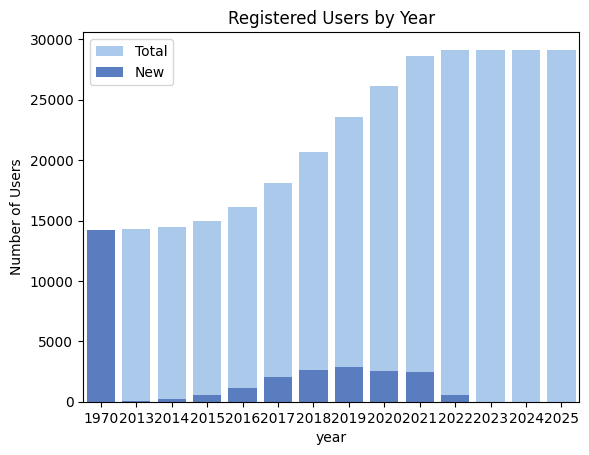

In [7]:
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="year", y="cumulative", data=count_by_year,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
plot = sns.barplot(x="year", y="active", data=count_by_year,
            label="New", color="b")

plot.set_title("Registered Users by Year")
plot.set_ylabel("Number of Users")

As we see, for many users information on account creation is missing. This seems to have started in 2021 or 2022.
Luckily, a few users have information logged in later years:

In [8]:
users[users.year>2021].drop_duplicates(subset="year", keep="first")

,active,year
29331,1,2022
35131,1,2023
40661,1,2024
46774,1,2025


In [9]:
users[users.year>2021].drop_duplicates(subset="year", keep="last")

,active,year
33021,1,2022
39134,1,2023
46144,1,2024
47067,1,2025


Since user ids are sequential, we can use these fairly reliable to impute the missing creation years.

In [10]:
users.loc[users.year == 1970, 'year'] = float('nan')

In [11]:
first = users[users.year>2021].drop_duplicates(subset="year", keep="first")["year"].to_dict()
last = users[users.year>2021].drop_duplicates(subset="year", keep="last")["year"].to_dict()
borders = first | last

In [12]:
def fill_nearest(row):
    nearest_id, year = min((abs(row.name - border_id), year) for border_id, year in borders.items())
    row['year'] = year
    return row

In [13]:
imputed_years = users[users['year'].isna()].apply(fill_nearest, axis=1)

In [14]:
assert users['year'].isna().sum() == len(imputed_years), "Should only have imputation data for missing values"

In [15]:
users.loc[imputed_years.index, 'year'] = imputed_years['year']

Some sanity checks: no more missing years. The item after the last entry from 2023 is backfilled, while the entry before the first one from 2024 is forward filled:

In [16]:
assert not users['year'].isna().any()

In [17]:
users.loc[[39134, 39135, 40660, 40661]]

,active,year
39134,1,2023.0
39135,1,2023.0
40660,1,2024.0
40661,1,2024.0


In [22]:
count_by_year = users.groupby(["year"], as_index=False).count()
count_by_year["cumulative"] = count_by_year["active"].cumsum()

count_by_year['year'] = count_by_year['year'].astype(int)
count_by_year = count_by_year[count_by_year['year'] < 2025]
count_by_year.head()

,year,active,cumulative
0,2013,39,39
1,2014,202,241
2,2015,516,757
3,2016,1108,1865
4,2017,2011,3876


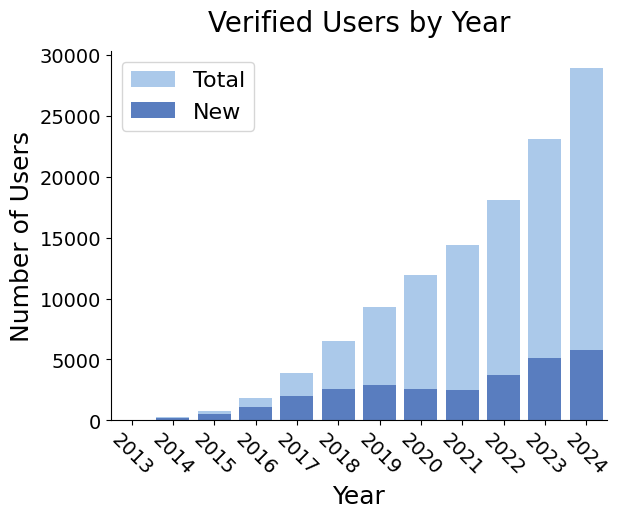

In [21]:
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="year", y="cumulative", data=count_by_year,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
plot = sns.barplot(x="year", y="active", data=count_by_year,
            label="New", color="b")

plot.set_title("Verified Users by Year", fontsize=20, y=1.03)
plot.set_ylabel("Number of Users", fontsize=18)
plot.set_xlabel("Year", fontsize=18)

plot.tick_params(axis='y', which='major', labelsize=14)
plot.tick_params(axis='x', which='major', labelsize=14, labelrotation=-45)
plot.legend(fontsize=16)
sns.despine(ax=plot)

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(root / "figures/users_by_year.pdf") as fh:
    fh.savefig(plot.get_figure(), bbox_inches="tight")